###### PreProcessing

In [1]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import shap

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
data = pd.read_csv('DS_dataset.csv')
data

,Customer_ID,Var1,Var2,Group,Category,Rating,Purchased_ABC_product
0,5518,41.534,12.123,G1,C1,Bronze,0
1,40515,9.445,0.256,G1,C1,Bronze,0
2,52697,37.599,3.199,G1,C2,Gold,0
3,68202,81.514,1.645,G1,C1,Silver,0
4,130003,46.805,1.706,G1,C1,Silver,0
...,...,...,...,...,...,...,...
30824,7047231,12.094,0.899,G5,C3,Bronze,1
30825,7079889,43.214,6.484,G5,C1,Bronze,1
30826,7155901,20.902,6.159,G5,C1,Bronze,1
30827,7180919,11.443,0.000,G5,C3,Bronze,0


###### Data Cleaning
- There are no duplicates and no missing values
- Deal with outliers in Var1 and Var2

In [3]:
#function to identify and return the outliers
outliers=[]
def detect_outlier(x):
    threshold=3
    mean = np.mean(x)
    std = np.std(x)
    for i in x:
        z = (i-mean)/std
        if threshold < np.abs(z):
            outliers.append(i)     
    return(outliers)

In [4]:
len(detect_outlier(data['Var1']))

635

In [5]:
len(detect_outlier(data['Var2']))

1223

Almost 4 percentage of Var1 and 7 percentage of Var2 are outliers. 
Methods to deal with outliers:
- Delete them
- Cap and floor them
- Replace with mean or median

Going forward with any of these methods doesn't seem correct. Because it's a huge number to delete and as the feature is not truly known we might lose a lot of important data if we do so. Capping them or replacing would lead to very large number of values having the same value which might be whole different problem. 
- So I will just let them be and choose an appropriate model that would not be affected very much by outliers.

###### Data Transformation

In [6]:
#reduce the skewness in var1 and var2
#perform log transformation on var1, var2 to remove skewness
data['Var1'] = np.log(data['Var1'])

In [7]:
#check for zeroes because they raise an error as log of zero is not defined
data[data['Var2'] == 0]

,Customer_ID,Var1,Var2,Group,Category,Rating,Purchased_ABC_product
13,417265,3.126717,0.0,G1,C1,Bronze,0
16,695148,2.258842,0.0,G1,C1,Bronze,0
19,721109,3.325719,0.0,G1,C5,Silver,0
32,828848,1.724194,0.0,G1,C1,Bronze,0
39,1271374,2.139360,0.0,G4,C1,Bronze,0
...,...,...,...,...,...,...,...
30784,4761165,2.637985,0.0,G1,C1,Bronze,0
30793,5925222,0.576613,0.0,G1,C1,Bronze,0
30808,6659096,3.143419,0.0,G5,C3,Bronze,0
30815,6833677,2.523486,0.0,G1,C1,Bronze,0


- 4192 rows have 0 at var2. Increment var2 with 1 and find the log of those values

In [8]:
data['Var2'] = np.log(data['Var2']+1)

<AxesSubplot:xlabel='Var2', ylabel='Count'>

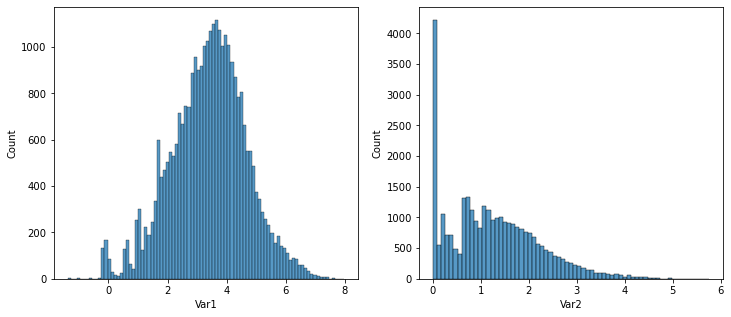

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(data['Var1'])

plt.subplot(1,2,2)
sns.histplot(data['Var2'])

- We achived an approximate normal distribution for var1.
- We also achieved a distribution similar to normal for var2 except for the huge spike at the start. This spike is due to all the zeroes present in var2 that were converted to 1 and then transformed.

In [10]:
#data scaling - normalization
N = MinMaxScaler()

In [11]:
data_norm = N.fit_transform(data[['Var1','Var2']])
data_new = pd.DataFrame(data_norm)

In [12]:
data['Var1'] = data_new[0]
data['Var2'] = data_new[1]

In [13]:
#encoding
data['Rating']=data['Rating'].replace({'Gold':2 , 'Silver':1,'Bronze':0})

In [14]:
#group and category have values with more than 2 categories and are nominal so use label encoder to encode those values 
feature_col = ['Group','Category']
le = LabelEncoder()
for col in feature_col:
    data[col] = le.fit_transform(data[col])
    data[col] = le.fit_transform(data[col])

In [15]:
data

,Customer_ID,Var1,Var2,Group,Category,Rating,Purchased_ABC_product
0,5518,0.545922,0.446687,0,0,0,0
1,40515,0.387661,0.039549,0,0,0,0
2,52697,0.535286,0.248965,0,1,2,0
3,68202,0.617973,0.168771,0,0,1,0
4,130003,0.558690,0.172728,0,0,1,0
...,...,...,...,...,...,...,...
30824,7047231,0.414080,0.111279,4,2,0,1
30825,7079889,0.550160,0.349242,4,0,0,1
30826,7155901,0.472546,0.341539,4,0,0,1
30827,7180919,0.408167,0.000000,4,2,0,0


- The final data is ready. Proceed to model building and selection

In [16]:
features = ['Group','Category','Rating','Var2','Var1']
x = data[features]
y = data['Purchased_ABC_product']

In [17]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=4)

##### Decision tree

In [18]:
dtcl = tree.DecisionTreeClassifier()
dtcl.fit(x_train,y_train)
y_pred_dt = dtcl.predict(x_test)
accuracy_score(y_test,y_pred_dt)

0.7051115723923197

In [19]:
matrix = metrics.confusion_matrix(y_test,y_pred_dt)
recall = recall_score(y_test,y_pred_dt)
precision = precision_score(y_test,y_pred_dt)
f1 = f1_score(y_test,y_pred_dt)
print('Precision:',precision, 'Recall:',recall,'F1 score:',f1)

Precision: 0.7083333333333334 Recall: 0.7048673705897502 F1 score: 0.7065961017167937


##### Random Forest

In [20]:
rc = RandomForestClassifier(max_depth=2, random_state=7)
rc.fit(x_train, y_train)
y_pred_rc = rc.predict(x_test)
accuracy_score(y_test,y_pred_rc)

0.7531136481577582

In [21]:
matrix1 = metrics.confusion_matrix(y_test,y_pred_rc)
recall1 = recall_score(y_test,y_pred_rc)
precision1 = precision_score(y_test,y_pred_rc)
f1_1 = f1_score(y_test,y_pred_rc)
print('Precision:',precision1, 'Recall:',recall1,'F1 score:',f1_1)

Precision: 0.7275862068965517 Recall: 0.81509142415658 F1 score: 0.768857038746508


##### Logistic regression

In [22]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
accuracy_score(y_test,y_pred)

0.7611572392319668

In [23]:
recall2 = recall_score(y_test,y_pred)
precision2 = precision_score(y_test,y_pred)
f1_2 = f1_score(y_test,y_pred)
print('Precision:',precision2, 'Recall:',recall2,'F1 score:',f1_2)

Precision: 0.7803404722679846 Recall: 0.7319083183105846 F1 score: 0.7553488372093022


In [24]:
metrics.roc_auc_score(y_test, y_pred)

0.7613789957565995

In [25]:
metrics.confusion_matrix(y_test,y_pred)

array([[3025,  800],
       [1041, 2842]], dtype=int64)

In [26]:
#find probability of purchase
px = np.array(data[features])

In [27]:
probability = lr.predict_proba(px)

In [28]:
Prob = pd.DataFrame(probability)

In [29]:
data['Probability of Purchase'] = Prob[1]

In [30]:
data

,Customer_ID,Var1,Var2,Group,Category,Rating,Purchased_ABC_product,Probability of Purchase
0,5518,0.545922,0.446687,0,0,0,0,0.900413
1,40515,0.387661,0.039549,0,0,0,0,0.115139
2,52697,0.535286,0.248965,0,1,2,0,0.654494
3,68202,0.617973,0.168771,0,0,1,0,0.343526
4,130003,0.558690,0.172728,0,0,1,0,0.365221
...,...,...,...,...,...,...,...,...
30824,7047231,0.414080,0.111279,4,2,0,1,0.307975
30825,7079889,0.550160,0.349242,4,0,0,1,0.792184
30826,7155901,0.472546,0.341539,4,0,0,1,0.789795
30827,7180919,0.408167,0.000000,4,2,0,0,0.119024


In [31]:
data.to_csv('Final data.csv',index=False)